# Importing and cleaning the data

In [2]:
import pandas as pd 
import json
import numpy as np


In [3]:
pd.set_option('max_colwidth', 50)
pd.set_option('display.max_columns', 80)

In [4]:
import json

# Load JSON data from a file
with open('assets/my_topics.json') as file:
    json_data = json.load(file)

# Convert JSON data to a dictionary
my_topics = dict(json_data)

# Load JSON data from a file
with open('assets/wpf_topics.json') as file:
    json_data = json.load(file)

# Convert JSON data to a dictionary
topics_wfp = dict(json_data)

In [5]:
for title, topics_list in topics_wfp.items():
    adjusted_topics = []
    for topic in topics_list:
        adjusted_topics.extend(topic.split(','))
    topics_wfp[title] = adjusted_topics


# Data cleaning books df
- page count categories
- filter if book is read of not 

In [6]:
mybooks = pd.read_parquet("assets/my_book_df.parquet")
# mybooks = mybooks.rename(columns=lambda x: x.replace(' ', '_')) 


In [7]:
def categorize_pages(number_of_pages):
    if number_of_pages >= 100 and number_of_pages <= 249:
        return '100-249'
    elif number_of_pages >= 250 and number_of_pages <= 349:
        return '250-349'
    elif number_of_pages >= 350 and number_of_pages <= 449:
        return '350-449'
    elif number_of_pages >= 450 and number_of_pages <= 599:
        return '450-599'
    elif number_of_pages >= 600 and number_of_pages <= 749:
        return '600-749'
    elif number_of_pages >= 750 and number_of_pages <= 999:
        return '750-999'
    else:
        return '1000+'

# Apply the categorize_pages function to create the 'Page_Cat' column
mybooks['Page_Cat'] = mybooks['Number_of_Pages'].apply(categorize_pages)

# Define the desired order of categories
category_order = ['100-249', '250-349', '350-449', '450-599', '600-749', '750-999', '1000+']

# Convert the 'Page_Cat' column to a categorical variable with the specified order
mybooks['Page_Cat'] = pd.Categorical(mybooks['Page_Cat'], categories=category_order, ordered=True)


In [8]:
mybooks = mybooks.drop_duplicates(subset=['Title', 'Author'])

In [9]:
# Create year and quarter read variable 

#  Impute data_added where date_read  is na
mybooks['Date_Read'] = np.where(mybooks['Date_Read'].isnull() & mybooks['Read_Count']==1, mybooks['Date_Added'], mybooks['Date_Read'])

# Convert 'Date_Read' column to datetime type
mybooks['Date_Read'] = pd.to_datetime(mybooks['Date_Read'], format='mixed')

# Extract year and quarter from 'Date_Read' column
mybooks['Year'] = mybooks['Date_Read'].dt.year
mybooks['Quarter'] = mybooks['Date_Read'].dt.quarter

# Create a new column combining year and quarter
mybooks['Year_Quarter'] = np.where(mybooks['Date_Read'].notnull(), mybooks['Year'].astype(str) + '-Q' + mybooks['Quarter'].astype(str), np.nan)
# Replace '.0' in the Year_Quarter column with an empty string
mybooks['Year_Quarter'] = mybooks['Year_Quarter'].fillna('').str.replace('.0', '')

# Convert Year_Quarter to categorical variable
mybooks['Year_Quarter'] = pd.Categorical(mybooks['Year_Quarter'], ordered=True)

In [10]:
# filter na in publication year and make column publication year integer 
mybooks = mybooks.dropna(subset=['Original_Publication_Year'])
mybooks['Original_Publication_Year'] = mybooks['Original_Publication_Year'].astype(int)

In [11]:
# Making sure all na is set as np.nan and not as a string variable (had this issue with one variable)
import numpy as np
mybooks = mybooks.replace('nan', np.nan)
mybooks = mybooks.replace('NaN', np.nan)

In [12]:
# # filer only books I have read
myreads = mybooks.query("Read_Count == 1")
to_read = mybooks.query("Exclusive_Shelf == 'to-read'")

In [13]:
myreads['Date_Read'] = myreads['Date_Read'].fillna(myreads['Date_Added'].copy())
myreads = myreads.sort_values(by='Date_Read')

/var/folders/v0/_5v45j6d3wg4y2hgk4psz0sm0000gn/T/ipykernel_7953/3780009989.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  myreads['Date_Read'] = myreads['Date_Read'].fillna(myreads['Date_Added'].copy())


In [16]:
# creating dictionaries for read and want-to-read books
my_read_topics = {k: v for k, v in my_topics.items() if k in myreads.Title.to_list()}
my_want_titles = list(set(list(my_topics.keys())) - set(myreads.Title.to_list()))
my_want_topics = {k: v for k, v in my_topics.items() if k in my_want_titles}

# Topics visualization 

In [14]:
from apps.viz import tree_topics

In [17]:
fig = tree_topics(my_read_topics)
fig.show()

In [81]:
fig = tree_topics(my_want_topics)
fig.show()

# vizualising publication year

In [82]:
from apps.viz import viz_pub_year
fig = viz_pub_year(myreads)
fig.show()

# Vizualising timeline of books read. 

In [110]:
from apps.viz import viz_year_read
viz_year_read(myreads).show()

# Number of pages and read count

Visualising the most read page count of books

In [111]:
from apps.viz import visualize_page_categories

# Assuming you have a DataFrame 'myreads' with 'Page_Cat' column

visualize_page_categories(myreads, 'Page_Cat')



# Vizualise top categories and languages
I am using a pie chart here because I excpect few values in each variable and a large discrepancy.

In [19]:
from apps.viz import viz_top_values

In [158]:
# pie chart, top 5 categories and languages
import plotly.graph_objects as go

def viz_top_values(column, top_n=5):
    # Drop NaN values from the column
    column = column.dropna()
    value_col = column.value_counts().reset_index()

    if len(value_col) > top_n: 
        remaining_count =value_col['count'].iloc[top_n:].sum()
        other = pd.DataFrame([['Other', remaining_count]], columns=[value_col.columns[0], 'count'])
        val_df =  pd.DataFrame(pd.concat([value_col.head(top_n), other]))
    else:
        val_df = pd.DataFrame(value_col)


    labels = val_df.iloc[:, 0]
    values = val_df['count']

    # Define the color theme
    colors = ['rgb(244, 202, 228)','rgb(179, 226, 205)', 'rgb(253, 205, 172)', 'rgb(203, 213, 232)',
               'rgb(230, 245, 201)', 'rgb(255, 242, 174)',
               'rgb(241, 226, 204)', 'rgb(204, 204, 204)', 'rgb(255, 255, 204)',
               'rgb(197, 226, 255)', 'rgb(200, 200, 200)']  # Adding color for "Other"

    # Create the pie chart
    fig = go.Figure(data=[go.Pie(labels=labels, values=values)])

    # Set the colors using the color theme
    fig.update_traces(marker=dict(colors=colors))

    # Set the chart title
    fig.update_layout(title=f'Top {top_n} Values of {column.name}')

    # Display the chart
    fig.show()


In [159]:
viz_top_values(mybooks['Language'], top_n=5)

In [160]:
viz_top_values(mybooks['Categories'], top_n=10)

In [164]:
viz_top_values(mybooks['Publisher'], top_n=10)

## Rating visualised 

In [162]:
def plot_book_ratings(data):
    # Filter the data where My_Rating > 0 since this would include non rated books

    # Sort the filtered data by your own rating in descending order
    sorted_data = (
        data.query('My_Rating > 0')
        .drop_duplicates(subset=['Title', 'Author'])
        .sort_values(['My_Rating', 'Date_Read'], ascending=False)
    )
    # Select the top 10 and bottom 10 books based on your own rating
    top_books = sorted_data.head(10)
    bottom_books = sorted_data.tail(10)

    # Create the figure object with subplots
    fig = make_subplots(rows=2, cols=1, subplot_titles=("My highest Rated Books", "My lowest Rated Books"))

    # Define the Pastel1 color scheme
    pastel_colors = plotly.colors.qualitative.Pastel1

    # Add traces for top rated books
    fig.add_trace(go.Bar(
        y=top_books['Title'],
        x=top_books['My_Rating'],
        name='My Rating',
        orientation='h',
        marker=dict(color=pastel_colors[3]),
        legendgroup='My Rating'
    ), row=1, col=1)

    fig.add_trace(go.Bar(
        y=top_books['Title'],
        x=top_books['Average_Rating_GoogleBooks'],
        name='Average Rating (Google Books)',
        orientation='h',
        marker=dict(color=pastel_colors[4]),
        legendgroup='Average Rating (Google Books)'
    ), row=1, col=1)

    fig.add_trace(go.Bar(
        y=top_books['Title'],
        x=top_books['Average_Rating_Goodreads'],
        name='Average Rating (Goodreads)',
        orientation='h',
        marker=dict(color=pastel_colors[5]),
        legendgroup='Average Rating (Goodreads)'
    ), row=1, col=1)

    # Add traces for bottom rated books
    fig.add_trace(go.Bar(
        y=bottom_books['Title'],
        x=bottom_books['My_Rating'],
        name='My Rating',
        orientation='h',
        marker=dict(color=pastel_colors[3]),
        legendgroup='My Rating',
        showlegend=False,
    ), row=2, col=1)

    fig.add_trace(go.Bar(
        y=bottom_books['Title'],
        x=bottom_books['Average_Rating_GoogleBooks'],
        name=' ',
        orientation='h',
        marker=dict(color=pastel_colors[4]),
        legendgroup='Average Rating (Google Books)',
        showlegend=False,
    ), row=2, col=1)

    fig.add_trace(go.Bar(
        y=bottom_books['Title'],
        x=bottom_books['Average_Rating_Goodreads'],
        name='Average Rating (Goodreads)',
        orientation='h',
        marker=dict(color=pastel_colors[5]),
        legendgroup='Average Rating (Goodreads)',
        showlegend=False,
    ), row=2, col=1)

    # Update the layout
    fig.update_layout(
        title='Book Ratings<span style="font-size: 10px;"><br>Showing the latest read books</span>',
        showlegend=True,
        height=900,
        width=800,
        plot_bgcolor='rgba(255, 255, 255, 1)',
        paper_bgcolor='rgba(255, 255, 255, 1)',
        yaxis=dict(title='Title', side='top', showticklabels=True),
        xaxis=dict(title='Rating'),
        barmode='group',
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.05,
            xanchor="right",
            x=1.4
            )
    )
    fig.show()

In [163]:
# from apps.viz import plot_book_ratings

plot_book_ratings(myreads)


In [90]:


from apps.viz import create_rating_table

# Call the function to create the rating table
rating_table = create_rating_table(myreads)

# Display the table
rating_table.show()


In [164]:
from apps.viz import create_author_table
# Call the function to create the author table
author_table = create_author_table(myreads)

# Display the table
author_table.show()

# This year in books

In [174]:
from datetime import datetime
datetime.today().year

2023

In [185]:
# Filter on books read this year using datetime to find todays year
from datetime import datetime
today_year = datetime.today().year
print(f"This year you have read {len(myreads.query('Year == @today_year'))} books. Totaling {f'{(myreads.Number_of_Pages.sum().astype(int)):,}'} pages read.")

This year you have read 37 books. Totaling 54,436 pages read.


# Word cloud from Goodreads book Description

In [203]:

import numpy as np
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [241]:
STOPWORDS.update({'Author', 'S', 'will','New','York','Time','book','novel', 'read', 'day', 'make','year', 'one', 'times', 'Times'})

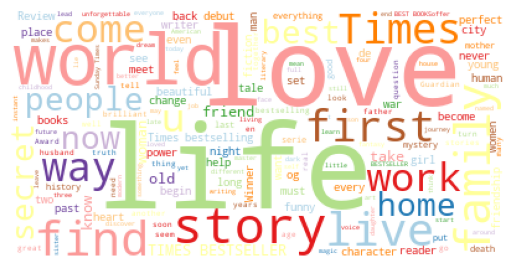

In [240]:
# Drop the rows with null values in the 'Description' column
descriptions = mybooks['Description'].dropna()
wc = WordCloud(background_color = 'white',stopwords = STOPWORDS, contour_width = 2,
     contour_color = 'white', colormap = 'Paired').generate(' '.join(descriptions))
plt.axis("off")
plt.imshow(wc)

In [242]:
print('helo')

helo
